<a href="https://colab.research.google.com/github/simulate111/Production-Optimization/blob/main/Circlepacking_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All installations must be done every time you re-open a notebook and want to run it. Google Colab has many packages already installed, which you normally would need to install, such as nympy, scipy , matplotlib, plotly, pandas. Most of these also come with Anaconda (except plotly).

Adding text and code is done with "+ Code" or "+ Text" Sections can easily be moved or deleted. To run a code you need to press the play buttom that appears when you move the cursor over a code block.

First we install Pyomo (in quiet mode). Since you will need to use
Runtime->Run all if you re-define a Pyomo model, we add a try-except construction to the Python code to check if Pyomo is already installed. The "!" allows us to run the command (as in a terminal).

For this example we need the NLP solver ipopt. This is distributed with the larger package idaes (and now it seems that this solver should be called as ipopt_l1, this may change again).

In [1]:
#install pyomo and solvers from the IDAES project
#this installs several solvers like ipopt, cbc, bonmin but takes some time to run
#it seems that ipopt is now under the name ipop_l1 or ipopt_sens here?
try:
  not_first_time == True
except:
  !pip install idaes-pse --pre
  !idaes get-extensions --to ./bin
  not_first_time = True
finally:
  print("Pyomo and solvers installed")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 11.3 MB/s eta 0:00:00
Getting files...
Done
-----------------------------------------------------------------
IDAES Extensions Build Versions
Solvers:  v3.4.2 20240811 ubuntu2204-x86_64
Library:  v3.4.2 20240811 ubuntu2204-x86_64

Pyomo and solvers installed


The problem in compact form:

$ \min \: w \cdot h$

s.t

$x_c \ge r_c \:\: \forall c \in C$

$x_c + r_c \le w \:\: \forall c \in C$

$y_c \ge r_c \:\: \forall c \in C$

$y_c + r_c \le h \:\: \forall c \in C$

$(x_c-x_{c^\prime})^2+(y_c-y_{c^\prime})^2 \ge (r_c+r_{c^\prime})^2 \:\: \forall c,c^{\prime} \in C,c \lt c^{\prime}$

$h,w,x_c,y_c \in \mathbb{R}_{\ge 0}, C=\{c_1,c_2,c_3,c_4\}$



The radius of the circles, from 1 to 4, are 3, 3, 2 and 3, respectively.

When you are done with the this problem, add a cicle with your name and a radius

In [2]:
from pyomo.environ import *
import matplotlib.pyplot as plt
#return this cell if you make changes

m=ConcreteModel()

#Sets Set(initialize=,doc='')
m.C = Set(initialize=[1,2,3,4],doc='Circle indices')

#Parameters Param(initialize={key:values},doc='')
m.r = Param(m.C,initialize={1:3,2:3,3:2,4:3},doc='Circle radii')

#Variables Var(within=NonNegativeReals,doc='') (Startig guesses can be given with initialize={key:values}, usually no need)
m.x = Var(m.C,within=NonNegativeReals,doc='Circle x coordinates')
m.y = Var(m.C,within=NonNegativeReals,doc='Circle y coordinates')
m.w = Var(within=NonNegativeReals,doc='Total width')
m.h = Var(within=NonNegativeReals,doc='Total height')

#Objective Objective(expr= , sense=minimize, doc='')
m.obj = Objective(expr=m.w*m.h,sense=minimize,doc="Minimize total area")

#Constraints Constraint(rule= ,doc='')
def left_rule(m,c):
  return m.x[c] >= m.r[c]
m.left = Constraint(m.C,rule=left_rule,doc='Keep circles within left border')

def right_rule(m,c):
  return m.x[c] + m.r[c] <= m.w
m.right = Constraint(m.C,rule=right_rule,doc='Keep circles within right border')

def bottom_rule(m,c):
  return m.y[c] >= m.r[c]
m.bottom = Constraint(m.C,rule=bottom_rule,doc='Keep circles within bottom border')

def top_rule(m,c):
  return m.y[c] + m.r[c] <= m.h
m.top = Constraint(m.C,rule=top_rule,doc='Keep circles within top border')

def overlap_rule(m,c,cp):
  if c >= cp:
    return Constraint.Skip
  else:
    return (m.x[c] - m.x[cp])**2 + (m.y[c] - m.y[cp])**2 >= (m.r[c] + m.r[cp])**2
m.overlap = Constraint(m.C,m.C,rule=overlap_rule,doc='Prevent circles from overlapping')

m.pprint()


1 Set Declarations
    C : Circle indices
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {1, 2, 3, 4}

1 Param Declarations
    r : Circle radii
        Size=4, Index=C, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :     3
          2 :     3
          3 :     2
          4 :     3

4 Var Declarations
    h : Total height
        Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    w : Total width
        Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    x : Circle x coordinates
        Size=4, Index=C
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  None :  None : False :  True : NonNegativeReals
          2 :     0 :  None :  None :

In [3]:
#Solve in a separate stage, since we need to build the model first. When ready, one cell would do.
#added path to the excecutable, seems to be necessary
solver = SolverFactory("ipopt_l1",executable="/content/bin/ipopt_l1") #it used to be ipopt...

#solver = SolverFactory("couenne",executable="/content/bin/couenne") #this may take forever with large problems, restrict time using a opt-file
#with open("couenne.opt","w") as file:
#    file.write("time_limit 30")

results = solver.solve(m, keepfiles=False, tee=True)
#m.display()

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

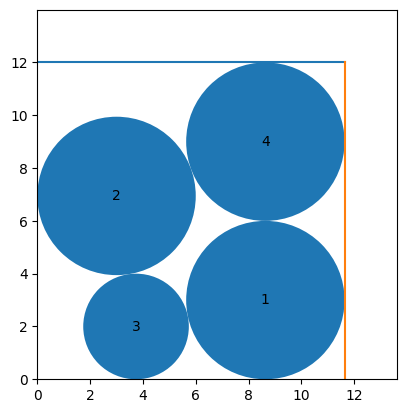

In [4]:
#Code for plotting the solution
figure, axes = plt.subplots()
for c in m.C:
    draw_circle = plt.Circle((m.x[c].value, m.y[c].value),m.r[c] )
    axes.add_artist(draw_circle)
    axes.text(m.x[c].value, m.y[c].value, c,
         horizontalalignment='center', verticalalignment='center')

plt.plot([0, m.w.value],[m.h.value, m.h.value])
plt.plot([m.w.value,m.w.value],[0, m.h.value])
axes.set_aspect(1)

plt.xlim(0,m.w.value+2)
plt.ylim(0,m.h.value+2)
plt.show()

In [5]:
#importing using dataframes from pandas via from excel is practical. For a simple excefile with headers in the first row and data i cells below this work
#(there are many ways to do the same thing)

#import pandas as pd
#
#df = pd.read_excel('circle_data.xlsx') #you need to upload the file to colab each session
#m.C = Set(initialize=df.set_index('circles').index.to_list(),doc='Circles')
#m.r = Param(m.C,initialize=df.set_index('circles')['radius'].to_dict(),doc='Radius of circle')



In [6]:
#something on dataframes

#df2=df.set_index('circles') #creates a new dataframe that has circles as indeces
#df2['radius'] #getting the elements in the column 'radius' as a series
#df2['radies'].to_dict() #convert the series to adictionarey
#df.set_index('circles')['radius'].to_dict() #everything in one step